In [1]:
%matplotlib inline
import sys
print(sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import io
import scipy

# Update the matplotlib configuration parameters:
mpl.rcParams.update({'font.size': 18, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


In [2]:
# Loading our data in its raw form

urlGam = "https://drive.google.com/uc?export=download&id=1TvbbCV-kJeNMuIORMyiMFgH_u_CQSZhX" # Make sure the url is the raw version of the file on GitHub
downloadGam = requests.get(urlGam).content
GamRaw = pd.read_csv(io.StringIO(downloadGam.decode('utf-8')))

urlNeut = "https://drive.google.com/uc?export=download&id=1bY6ZPF3WLxfviYSSViuw1SEx1_sWxP46" # Make sure the url is the raw version of the file on GitHub
downloadNeut = requests.get(urlNeut).content
NeutRaw = pd.read_csv(io.StringIO(downloadNeut.decode('utf-8')))

In [3]:
# Normalizing Data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(GamRaw)
scaledGam = scaler.transform(GamRaw)
GamNormal = pd.DataFrame(scaledGam, columns=GamRaw.columns)
GamNormal.head()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom
0,0.309014,0.500017,0.316455,0.391304,0.0,0.239100,0.571571,0.929306,0.954548,0.011228,0.374372
1,0.137330,0.168001,0.896980,0.391304,0.0,0.664525,0.537218,0.956967,0.966199,0.000418,0.677404
2,0.797621,0.147970,0.527490,0.347826,0.0,0.416199,0.587327,0.958785,0.960309,0.010556,0.305103
3,0.981994,0.664871,0.590116,0.413043,0.0,0.495234,0.658971,0.942428,0.954145,0.002930,0.693429
4,0.546102,0.456917,0.608336,0.434783,0.0,0.547988,0.708769,0.962667,0.961407,0.002104,0.885402


In [4]:
scaler.fit(NeutRaw)
scaledNeut = scaler.transform(NeutRaw)
NeutNormal = pd.DataFrame(scaledNeut, columns=NeutRaw.columns)
NeutNormal.head()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom
0,0.277350,0.506336,0.046628,0.050847,0.0,0.065102,1.000000,1.000000,0.845587,0.034378,0.681348
1,0.510501,0.641275,0.129485,0.220339,0.0,0.074894,0.338857,0.918015,0.887481,0.030818,0.883004
2,0.118249,0.458065,0.355208,0.355932,0.2,0.246332,0.483786,0.815185,0.866884,0.019507,0.799575
3,0.516117,0.509907,0.244931,0.288136,0.2,0.134062,0.447837,0.742040,0.734324,0.063638,0.908396
4,0.606277,0.264127,0.193122,0.220339,0.0,0.191992,0.916604,0.689069,0.883198,0.014785,0.944172


In [5]:
# Add a distriction column to the data, to know which is gam and which is neut for later graphing

GamNormal["distinction"] = 1
NeutNormal["distinction"] = 2

In [6]:
# Making the training data sets

GamTrain = GamNormal.sample(frac=0.05)
NeutTrain = NeutNormal.sample(frac=0.05)

In [7]:
# Have a look at the data.

# GamTrain.head()
print(NeutTrain.shape)
NeutTrain.head()

(2176, 12)


,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
29739,0.376251,0.028780,0.129400,0.203390,0.0,0.082187,0.364456,0.937806,0.868963,0.012351,0.834705,2
11410,0.874385,0.549817,0.068583,0.050847,0.0,0.045209,0.341676,1.000000,0.713680,0.172467,0.986572,2
26606,0.408969,0.423204,0.223064,0.305085,0.0,0.178483,0.546821,0.834995,0.887531,0.036051,0.975106,2
37436,0.607860,0.395699,0.381802,0.525424,0.0,0.171773,0.362977,0.553635,0.789791,0.043543,0.974267,2
6874,0.023353,0.415231,0.791653,0.508475,0.6,0.375763,0.382933,0.559997,0.589091,0.137855,0.957216,2


In [8]:
# gamTrain[['E']].describe()
GamTrain.describe()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
count,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2.168000e+03,2168.000000,2168.0
mean,0.488333,0.485731,0.550259,0.408311,0.004613,0.444398,0.630411,0.932928,0.949213,8.501753e-03,0.486882,1.0
std,0.291038,0.286640,0.223475,0.128137,0.030636,0.204655,0.181149,0.072256,0.036890,9.768266e-03,0.245892,0.0
min,0.001636,0.000000,0.000811,0.000000,0.000000,0.003511,0.074508,0.119453,0.595419,1.256300e-47,0.000000,1.0
25%,0.235097,0.232194,0.367737,0.326087,0.000000,0.277543,0.502114,0.929518,0.947648,3.799836e-03,0.291135,1.0
50%,0.479727,0.480695,0.544745,0.413043,0.000000,0.420518,0.673508,0.943778,0.956953,6.345310e-03,0.383203,1.0
75%,0.732755,0.728193,0.735937,0.500000,0.000000,0.598518,0.770591,0.957271,0.965289,9.875623e-03,0.709684,1.0
max,0.994681,0.999428,1.000000,0.826087,0.400000,0.977896,1.000000,1.000000,1.000000,1.797217e-01,0.999892,1.0


In [9]:
NeutTrain.describe()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
count,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.0
mean,0.433006,0.509868,0.197562,0.223665,0.024357,0.134998,0.525766,0.831604,0.809696,0.044406,0.778508,2.0
std,0.264151,0.289813,0.134649,0.138614,0.080542,0.093997,0.209501,0.157486,0.201744,0.069522,0.270199,0.0
min,0.002235,0.000081,0.000851,0.000000,0.000000,0.000657,0.058490,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.204183,0.264092,0.091990,0.118644,0.000000,0.064336,0.363562,0.746666,0.780252,0.009693,0.673992,2.0
50%,0.411841,0.499226,0.171422,0.203390,0.000000,0.119198,0.503446,0.868548,0.875026,0.022102,0.908698,2.0
75%,0.654649,0.773671,0.277568,0.305085,0.000000,0.186511,0.675600,0.958127,0.930880,0.045537,0.975095,2.0
max,0.943440,0.999847,0.891281,0.898305,1.000000,0.663928,1.000000,1.000000,1.000000,0.594354,0.999889,2.0


In [12]:
plotFrame = pd.concat([GamTrain, NeutTrain])

plotFrame.head(5)

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
27002,0.916318,0.417935,0.044368,0.065217,0.0,0.041468,0.689937,1.000000,0.984760,0.002192,0.075287,1
24000,0.422853,0.852330,0.645274,0.478261,0.0,0.457577,0.513799,0.930240,0.949360,0.006155,0.859210,1
34827,0.096462,0.950573,0.818658,0.565217,0.0,0.703827,0.681189,0.949856,0.951280,0.011240,0.364392,1
709,0.454218,0.698818,0.577933,0.456522,0.0,0.426358,0.539087,0.945357,0.961649,0.002904,0.289213,1
33535,0.512349,0.677712,0.363537,0.369565,0.0,0.315118,0.675009,0.960380,0.965383,0.017167,0.274696,1


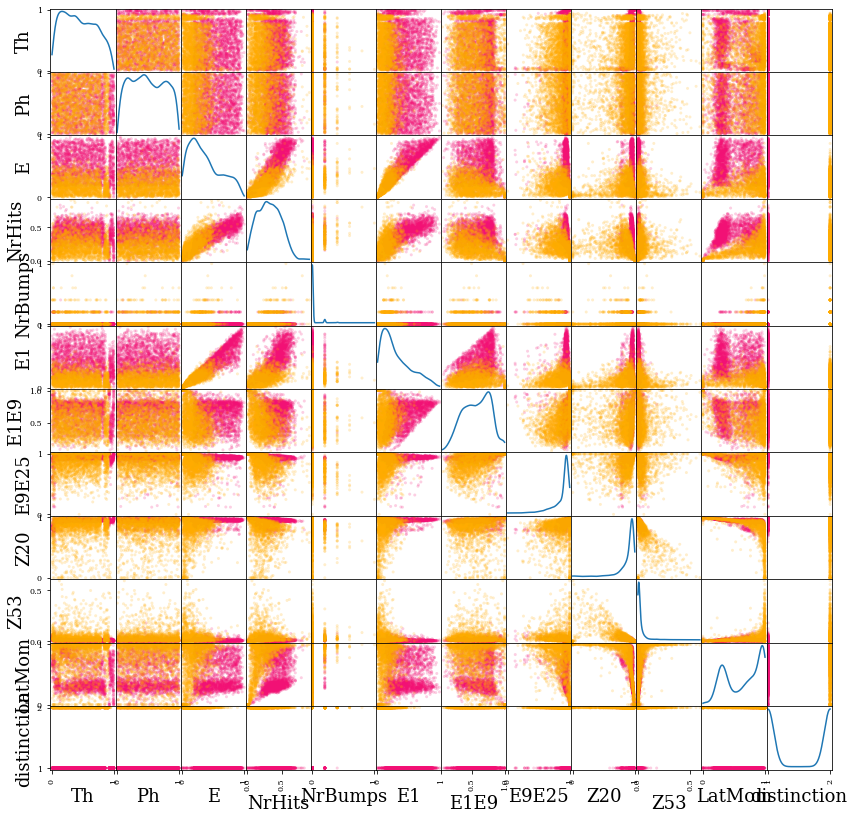

In [13]:
colors = ['#f21175', '#ffab00']

_ = pd.plotting.scatter_matrix(plotFrame, figsize=(14,14), diagonal='kde', alpha=0.2, color=[colors[x-1] for x in list(plotFrame.distinction)])


### Homework tasks:

   - Since we do have the true labels of each instance, setup a performance metric that returns the number of false labels (error rate) for each clustering algorithm.
   - Play with the clustering algorithms using higher dimensions, and verify that the error rate reduces.
   - Study other clustering methods than KMeans and MeanShift and compare pros and cons.

# Assignments
 - Read the two data files and visualize the various features comparing the responses for photons with that of neutrons. For those using Python, I strongly advice to make use of the pandas library [3]. For those using Mathematica, the easiest is to make use of Dataset [4]. Conclude from your observations and discuss and motivate which features you believe are likely to be the most powerful ones (and which not). Also study the correlations among the various features. What can you learn from that?
 - The next step is to setup the basics of the machine learning code. Develop a piece of code that returns the output of a supervised classifier, preferably also the FOM, whereby one can “easily” select the type of classifier (f.e. kNN, random forest, MLP, ...) and the list of features to be used as input. If you use Python, make use of the sklearn library [5]. In Mathematica, make use of the functionalities provided by Classify[...] [6].
 - Pick the features that you believe are the most powerful ones (from the visualization study), and optimize the internal parameters of a classifier you believe could be useful for this application (motivate your choice!). For instance, if you selected kNN, find the optimum “k” and the signal probability for the selected features that maximizes the FOM. Divide up the data sample in 50% training and 50% test and also consider to apply cross validation in your analysis. Do you see the effect of over- or underfitting?
 - Study the classifier outputs and FOM by varying the list of input features to the classifier. Which of the features does the classifier believe to be the most powerful ones, which are redundant or do not have any effect in the end result? Discuss your observations.
 - Extra: Compare the outcome of two different classifiers with each other. In the extreme case, you may even challenge yourself by comparing a supervised with an unsupervised method and compare their performances. Do you see differences in classification power, if so, could you explain why?